<a href="https://colab.research.google.com/github/nitesh0007-edith/Spotify-Music-Skips-Action-Prediction/blob/main/Model_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import pickle

In [93]:
#from google.colab import files
#files.upload()

In [94]:
#from google.colab import files
#files.upload()

In [78]:
# Load in the training set
training_set = pd.read_csv("train.csv")
training_set.hist_user_behavior_reason_start = training_set.hist_user_behavior_reason_start.astype('category')
training_set.hist_user_behavior_reason_end = training_set.hist_user_behavior_reason_end.astype('category')
training_set.context_type = training_set.context_type.astype('category')
training_set.date = training_set.date.apply(pd.to_datetime)

# Load in the track features
track_data = pd.read_csv("track.csv")

# Using skip_2 as the ground truth
training_set['skipped'] = (training_set.skip_2 | training_set.skip_1).astype('int32')
training_set = training_set.drop(columns=['skip_1','skip_2','skip_3','not_skipped'])
#training_set.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,4,5,6,7,14,16,17,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [79]:
training_set=training_set.dropna()

In [76]:
#training_set.isnull().sum()

In [77]:
#track_data.isnull().sum()

In [80]:
#track_data.head()

In [81]:
#track_data.info()

In [82]:
# Convert the columns to all be consistantly numeric
track_data.iloc[:,1:] = track_data.iloc[:,1:].astype('float32')
track_data.head()

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,is_major,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_7f435320-5d3b-497d-9346-0c97429af2b9,3.866097,0.441176,-0.403765,0.075846,0.499848,0.494943,0.461215,-0.208611,0.563252,0.916317,3.736224e-01,0.0,0.693975,-1.877277,0.187614,1.0,0.576942,0.065943,0.500154,0.571429,0.468440,1.034540,-1.040880,-1.281460,-0.375163,1.442307,0.045940,-0.443245,-0.243705
1,t_2a7b6393-ebec-4e1f-a53f-2ad842532c99,1.512969,0.308824,0.314153,0.085482,0.450139,0.457034,0.663219,-0.305010,0.767307,0.942687,1.000551e-06,0.0,0.290537,0.688374,0.549348,1.0,0.324341,0.046754,-0.461603,0.571429,0.655369,0.834594,-0.653568,-0.483167,-0.538935,1.247153,0.414248,-0.468285,-0.931875
2,t_949441c4-4920-4eed-b929-2d67d37b7bd9,-1.332280,0.485294,0.001032,0.002274,0.243778,0.229295,0.290262,-1.181899,0.958647,0.846197,5.658840e-02,0.0,0.259133,0.182698,0.332016,1.0,0.472339,0.115356,1.081277,0.571429,0.293100,0.846650,0.123691,-2.692681,-0.770798,1.533066,-0.173705,-0.402540,1.181761
3,t_63eae5ac-744a-46ee-b719-0db8e70d6f7f,-0.712162,0.485294,0.558944,0.005024,0.338580,0.331703,0.348846,-0.795663,0.886674,0.904784,1.998796e-10,0.0,0.381728,0.091084,0.185455,1.0,0.575982,0.137590,-0.657413,0.571429,0.387131,0.920349,0.335177,-2.631788,-1.033223,1.549514,-0.036511,-0.488062,1.028883
4,t_a0747d21-6042-4af7-a21d-aa7cd1a8094e,-1.629474,0.573529,-0.356946,0.962717,0.130125,0.092335,0.170027,-2.024206,0.005674,1.072822,9.604511e-01,0.0,0.092290,-5.961526,0.205882,1.0,0.882453,0.039092,-1.431127,0.428571,0.030858,2.238796,-3.259609,-2.378984,1.288895,-1.053248,-3.132838,0.946820,-0.623612


In [84]:
# Join the two together
session_data = (
    training_set[['session_id','session_position','track_id_clean', 'skipped']]
    .merge(
        track_data,
        how='left',
        left_on=['track_id_clean'],
        right_on=['track_id']
    ).drop(columns='track_id_clean')
)
#session_data.head()

In [85]:
full_session_data = pd.concat((
    session_data,
    session_data.drop(columns=['track_id'])\
        .groupby('session_id')\
        .shift(1)\
        .rename(columns={c:f"previous_{c}" for c in session_data.columns})
), axis=1)
#full_session_data.head()

In [86]:
# Examine the columns
#full_session_data.info()

In [87]:
# Split the data:
# df -> X, y -> Train, Test, Val
X = full_session_data.drop(
    columns=["skipped","session_id","track_id"]
).fillna(-9999)
y = full_session_data.skipped
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=2
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=2
)
#X.head(20)

In [88]:
from sklearn.preprocessing import StandardScaler

In [89]:
# Train a Logistic Regression model and score
scaler = StandardScaler().fit(X_train)
sX_train = scaler.transform(X_train)
sX_val = scaler.transform(X_val)
sX_test = scaler.transform(X_test)

log = LogisticRegressionCV(
    cv=3
).fit(
    sX_train,
    y_train
)

print("Log Train score: %s" % log.score(sX_train,y_train))
print("Log Val score:   %s" % log.score(sX_val,y_val))
print("Log Test score:  %s" % log.score(sX_test,y_test))

Log Train score: 0.5337900095864784
Log Val score:   0.527753992777633
Log Test score:  0.5309745055992375


In [90]:
log

LogisticRegressionCV(Cs=10, class_weight=None, cv=3, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [91]:
for pair in sorted(zip(X.columns,log.coef_[0]),key=lambda p: np.abs(p[1]),reverse=True):
    print("%30s | % .8f" % pair)

              previous_skipped |  0.06306652
     previous_session_position |  0.06172265
              session_position |  0.03304124
             previous_duration |  0.00099223
       previous_dyn_range_mean |  0.00097312
    previous_acoustic_vector_3 |  0.00096513
    previous_acoustic_vector_7 |  0.00096280
    previous_acoustic_vector_1 |  0.00096227
    previous_acoustic_vector_2 |  0.00095908
             previous_loudness |  0.00095761
                previous_tempo |  0.00093186
           previous_bounciness |  0.00093014
         previous_danceability |  0.00092788
        previous_beat_strength |  0.00092751
          previous_speechiness |  0.00092600
               previous_energy |  0.00092569
            previous_mechanism |  0.00092477
       previous_time_signature |  0.00092224
             previous_liveness |  0.00092197
             previous_flatness |  0.00092147
                  previous_key |  0.00091799
              previous_valence |  0.00091768
         p

In [92]:
# Train a Random Forest model and score
rfc = RandomForestClassifier(
    n_estimators=100
).fit(
    X_train,
    y_train
)

print("RFC Train score: %s" % rfc.score(X_train,y_train))
print("RFC Val score:   %s" % rfc.score(X_val,y_val))
print("RFC Test score:  %s" % rfc.score(X_test,y_test))

RFC Train score: 0.9653490688085776
RFC Val score:   0.7085737686608838
RFC Test score:  0.7080652847271861


In [ ]:
for pair in sorted(zip(X.columns,rfc.feature_importances_),key=lambda p:p[1],reverse=True):
    print("%30s | % .8f" % pair)

              previous_skipped |  0.20502936
     previous_session_position |  0.04348125
              session_position |  0.04338259
        us_popularity_estimate |  0.01663231
                      duration |  0.01500732
                      liveness |  0.01496414
                         tempo |  0.01471241
                       valence |  0.01453007
                   speechiness |  0.01450806
                      loudness |  0.01443886
             acoustic_vector_1 |  0.01432535
                  acousticness |  0.01430668
             acoustic_vector_6 |  0.01427219
                      flatness |  0.01424807
             previous_duration |  0.01414735
             acoustic_vector_2 |  0.01412019
             previous_loudness |  0.01407238
                     mechanism |  0.01404516
             acoustic_vector_7 |  0.01400500
                        energy |  0.01399126
previous_us_popularity_estimate |  0.01397333
             acoustic_vector_0 |  0.01389243
         

In [ ]:
# Train a XGBoost model and score
xgb = XGBClassifier(
    n_estimators=100000
).fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train),(X_val, y_val)],
    early_stopping_rounds=10,
    verbose=True
)

print("XGB Train score: %s" % xgb.score(X_train,y_train))
print("XGB Val score:   %s" % xgb.score(X_val,y_val))
print("XGB Test score:  %s" % xgb.score(X_test,y_test))

[0]	validation_0-error:0.270637	validation_1-error:0.273221
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.270637	validation_1-error:0.273221
[2]	validation_0-error:0.270637	validation_1-error:0.273221
[3]	validation_0-error:0.270637	validation_1-error:0.273221
[4]	validation_0-error:0.270637	validation_1-error:0.273221
[5]	validation_0-error:0.270637	validation_1-error:0.273221
[6]	validation_0-error:0.270637	validation_1-error:0.273221
[7]	validation_0-error:0.270869	validation_1-error:0.273408
[8]	validation_0-error:0.270869	validation_1-error:0.273408
[9]	validation_0-error:0.27086	validation_1-error:0.273296
[10]	validation_0-error:0.270851	validation_1-error:0.273333
Stopping. Best iteration:
[0]	validation_0-error:0.270637	validation_1-error:0.273221

XGB Train score: 0.729363476447977
XGB Val score:   0.7267786009456089
XGB Test score:  0.72

In [ ]:
for pair in sorted(zip(X.columns,xgb.feature_importances_),key=lambda p:p[1],reverse=True):
    print("%30s | % .8f" % pair)

              previous_skipped |  0.96810305
              session_position |  0.00789363
        us_popularity_estimate |  0.00510749
                 beat_strength |  0.00372679
             previous_duration |  0.00319069
    previous_acoustic_vector_7 |  0.00300647
    previous_acoustic_vector_0 |  0.00279730
previous_us_popularity_estimate |  0.00234995
    previous_acoustic_vector_4 |  0.00192855
                      duration |  0.00189618
                  release_year |  0.00000000
                  acousticness |  0.00000000
                    bounciness |  0.00000000
                  danceability |  0.00000000
                dyn_range_mean |  0.00000000
                        energy |  0.00000000
                      flatness |  0.00000000
              instrumentalness |  0.00000000
                           key |  0.00000000
                      liveness |  0.00000000
                      loudness |  0.00000000
                     mechanism |  0.00000000
         

In [ ]:
# Train a LightGBM model and score
lgbm = LGBMClassifier(
    n_estimators=100000
).fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train),(X_val, y_val)],
    early_stopping_rounds=10,
    verbose=True
)

print()
print("LGBM Train score: %s" % lgbm.score(X_train,y_train))
print("LGBM Val score:   %s" % lgbm.score(X_val,y_val))
print("LGBM Test score:  %s" % lgbm.score(X_test,y_test))

[1]	training's binary_logloss: 0.671615	valid_1's binary_logloss: 0.671996
Training until validation scores don't improve for 10 rounds.
[2]	training's binary_logloss: 0.65462	valid_1's binary_logloss: 0.6553
[3]	training's binary_logloss: 0.640663	valid_1's binary_logloss: 0.641689
[4]	training's binary_logloss: 0.62914	valid_1's binary_logloss: 0.630543
[5]	training's binary_logloss: 0.619669	valid_1's binary_logloss: 0.621397
[6]	training's binary_logloss: 0.611855	valid_1's binary_logloss: 0.613949
[7]	training's binary_logloss: 0.605367	valid_1's binary_logloss: 0.607797
[8]	training's binary_logloss: 0.60001	valid_1's binary_logloss: 0.602763
[9]	training's binary_logloss: 0.595509	valid_1's binary_logloss: 0.598613
[10]	training's binary_logloss: 0.591789	valid_1's binary_logloss: 0.595263
[11]	training's binary_logloss: 0.588704	valid_1's binary_logloss: 0.592432
[12]	training's binary_logloss: 0.586083	valid_1's binary_logloss: 0.590143
[13]	training's binary_logloss: 0.583874

LightGBM Classifier performance:

LGBM Train score: 0.7304338114162858

LGBM Val score:   0.7267041435538513

LGBM Test score:  0.7281391470097689

LGBM seems to have similar performance to XGB model (but faster).

Let's examine feature importance...

In [ ]:
for pair in sorted(zip(X.columns,lgbm.feature_importances_),key=lambda p:p[1],reverse=True):
    print("%34s | % 5d" % pair)

            us_popularity_estimate |    99
                  session_position |    76
                          duration |    63
        previous_acoustic_vector_0 |    53
   previous_us_popularity_estimate |    52
                 previous_duration |    47
                  previous_skipped |    45
                      release_year |    43
                      acousticness |    40
                          flatness |    37
                         mechanism |    37
                     beat_strength |    35
                 acoustic_vector_7 |    35
        previous_acoustic_vector_4 |    35
                 acoustic_vector_1 |    34
                 acoustic_vector_4 |    34
         previous_instrumentalness |    34
                 previous_loudness |    33
        previous_acoustic_vector_2 |    33
                  instrumentalness |    32
                 acoustic_vector_0 |    32
                 acoustic_vector_3 |    32
                 acoustic_vector_6 |    30
           

### Top 5 feature

In [ ]:
lgbm_feature_importances = [[p[0], int(p[1])] for p in sorted(zip(X.columns,lgbm.feature_importances_),key=lambda p:p[1],reverse=True)]
lgbm_feature_importances[:5]

[['us_popularity_estimate', 99],
 ['session_position', 76],
 ['duration', 63],
 ['previous_acoustic_vector_0', 53],
 ['previous_us_popularity_estimate', 52]]

### Plotting top 10 features

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '')

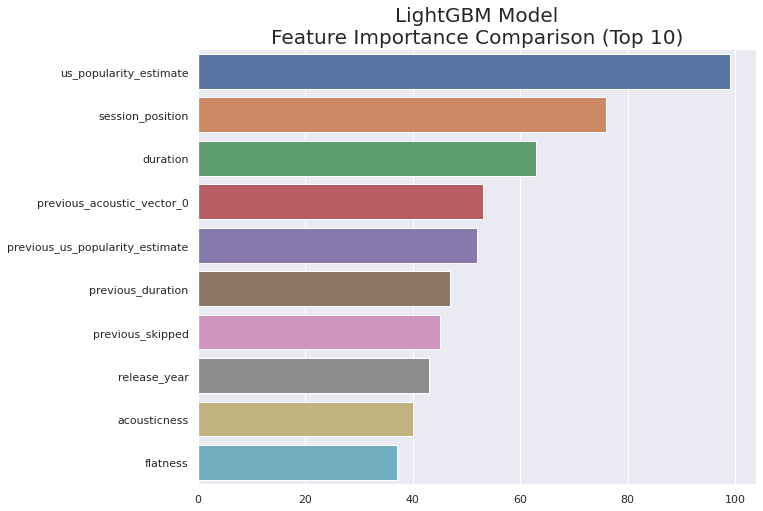

In [ ]:
fi = pd.DataFrame(lgbm_feature_importances,columns=['Feature','Importance'])

plt.figure(figsize=(10,8))
sns.barplot(
    "Importance",
    "Feature",
    data=fi.head(10)
)
plt.title(
    "LightGBM Model\nFeature Importance Comparison (Top 10)",
    fontsize=20
)
plt.xlabel(
    "",
    fontsize=15
)
plt.ylabel(
    "",
    fontsize=15
)
#plt.xticks(rotation=90)
#plt.tight_layout()
#plt.savefig("images/lgbm_feature_importance_top10.png")
#plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
print("Logistic Regression Confusion Matrix")
print(confusion_matrix(
    y_test,
    log.predict(X_test)
) / sum(y_test.shape))

Logistic Regression Confusion Matrix
[[0.09143436 0.39105313]
 [0.08163569 0.43587682]]


In [ ]:
print("Random Forest Confusion Matrix")
print(confusion_matrix(
    y_test,
    rfc.predict(X_test)
) / sum(y_test.shape))

Random Forest Confusion Matrix
[[0.34414463 0.13834286]
 [0.15424708 0.36326543]]


In [ ]:
print("XGBoost Confusion Matrix")
print(confusion_matrix(
    y_test,
    xgb.predict(X_test)
) / sum(y_test.shape))

XGBoost Confusion Matrix
[[0.36040624 0.12208125]
 [0.14954134 0.36797117]]


In [ ]:
print("LightGBM Confusion Matrix")
print(confusion_matrix(
    y_test,
    lgbm.predict(X_test)
) / sum(y_test.shape))

LightGBM Confusion Matrix
[[0.35915535 0.12333214]
 [0.14855849 0.36895401]]


In [ ]:
# # Save out the model
# with open("lgbm_model_0.73TestAcc.pkl","wb") as f:
 #    pickle.dump(lgbm,f)

In [ ]:
# Load in the model
#with open("lgbm_model_0.73TestAcc.pkl","rb") as f:
#    lgbm = pickle.load(f)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
def predict_proba(X):
    predictions = (
        log.predict_proba(scaler.transform(X))[:,1] +
        rfc.predict_proba(X)[:,1] +
        xgb.predict_proba(X)[:,1] +
        lgbm.predict_proba(X)[:,1]
    )
    return predictions / 4

def predict(X,threshold=0.5):
    return (predict_proba(X) > threshold).astype('float32')

def score(X,y):
    return accuracy_score(y,predict(X))

print("Ensemble Train Accuracy:  %.3f" % score(X_train,y_train))
print("Ensemble Val Accuracy:    %.3f" % score(X_val,y_val))
print("Ensemble Test Accuracy:   %.3f" % score(X_test,y_test))

Ensemble Train Accuracy:  0.858
Ensemble Val Accuracy:    0.723
Ensemble Test Accuracy:   0.725


In [ ]:
ensamble_predictions = predict(X_test)


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
lgbm_preds = lgbm.predict(X_test)

print("LightGBM Test Precision Score: %.3f" % precision_score(y_test,lgbm_preds))
print("LightGBM Test Recall Score:    %.3f" % recall_score(y_test,lgbm_preds))
print("LightGBM Test F1 Score:        %.3f" % f1_score(y_test,lgbm_preds))

LightGBM Test Precision Score: 0.749
LightGBM Test Recall Score:    0.713
LightGBM Test F1 Score:        0.731


In [ ]:
print("Ensemble Test Precision Score: %.3f" % precision_score(y_test,ensamble_predictions))
print("Ensemble Test Recall Score:    %.3f" % recall_score(y_test,ensamble_predictions))
print("Ensemble Test F1 Score:        %.3f" % f1_score(y_test,ensamble_predictions))

Ensemble Test Precision Score: 0.743
Ensemble Test Recall Score:    0.715
Ensemble Test F1 Score:        0.729


Let's look at the residuals for the best model (LightGBM) and see if we can find a cause

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


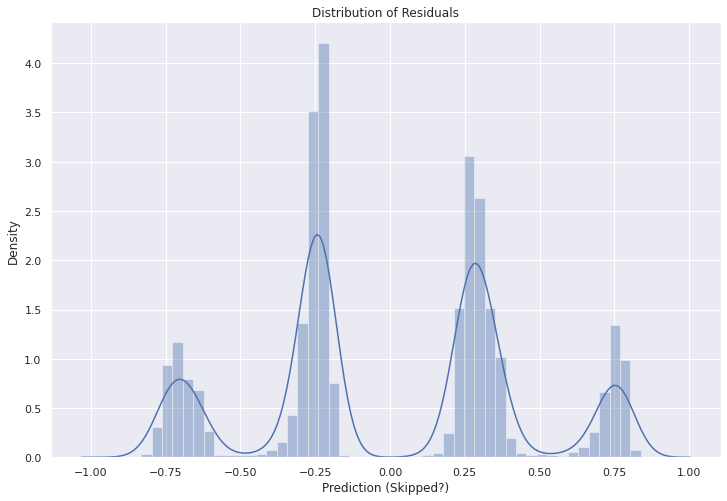

In [ ]:
lgbm_probs = lgbm.predict_proba(X_test)[:,1]
lgmb_residuals = (lgbm_probs - y_test).sort_values()

plt.figure(figsize=(12,8))
sns.distplot(lgmb_residuals)
plt.title("Distribution of Residuals")
plt.xlabel("Prediction (Skipped?)")
plt.show()


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


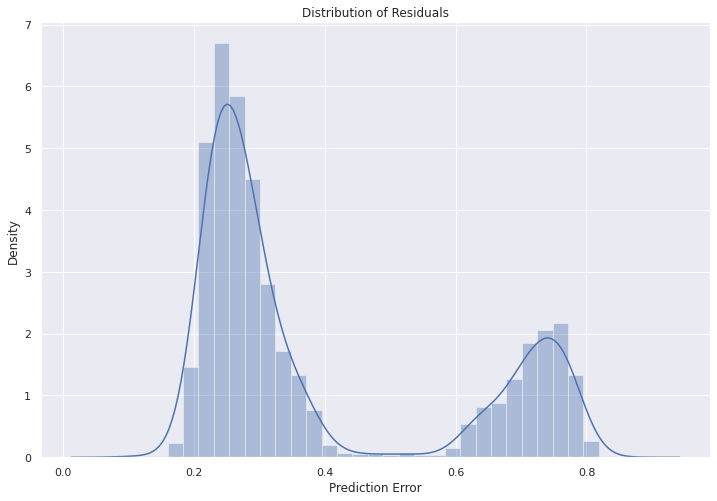

In [ ]:
plt.figure(figsize=(12,8))
sns.distplot(np.abs(lgmb_residuals))
plt.title("Distribution of Residuals")
plt.xlabel("Prediction Error")
plt.show()

In [ ]:
threshold = 0.6
print("Proportion of Residuals (Greater than %.2f):  %.4f" % (
    threshold,
    (np.abs(lgmb_residuals) > threshold).sum() / lgmb_residuals.count()
))

Proportion of Residuals (Greater than 0.60):  0.2659


In [ ]:
target_residuals = np.abs(lgmb_residuals) > threshold
target_residuals = target_residuals.sort_index()
target_residuals.head()

5     False
9     False
14     True
15    False
21    False
Name: skipped, dtype: bool

In [ ]:
X_test.sort_index().head()

,session_position,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,is_major,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,previous_session_position,previous_skipped,previous_duration,previous_release_year,previous_us_popularity_estimate,previous_acousticness,previous_beat_strength,previous_bounciness,previous_danceability,previous_dyn_range_mean,previous_energy,previous_flatness,previous_instrumentalness,previous_key,previous_liveness,previous_loudness,previous_mechanism,previous_is_major,previous_organism,previous_speechiness,previous_tempo,previous_time_signature,previous_valence,previous_acoustic_vector_0,previous_acoustic_vector_1,previous_acoustic_vector_2,previous_acoustic_vector_3,previous_acoustic_vector_4,previous_acoustic_vector_5,previous_acoustic_vector_6,previous_acoustic_vector_7
5,6.0,-0.079714,1.000000,0.713925,0.098337,0.548632,0.658323,0.596480,0.966162,0.557129,1.027320,7.479557e-08,0.090909,0.056493,0.115559,0.385027,0.0,0.440376,0.133586,0.406463,0.714286,0.661081,-1.336988,0.457133,1.093895,0.837688,-0.708546,0.469779,0.643404,0.871075,5.0,0.0,-0.154756,1.0,0.714545,0.006602,0.732428,0.794881,0.857778,1.680245,0.650057,1.000571,2.066649e-06,0.727273,0.120842,0.700050,0.759465,1.0,0.170148,0.240980,0.863928,0.571429,0.652921,-1.458160,0.623033,0.359345,0.291053,-0.843922,-0.390072,-1.023939,0.498887
9,10.0,-1.993436,1.000000,0.686116,0.332467,0.751500,0.843354,0.914082,2.600974,0.239318,1.040802,4.132156e-04,0.363636,0.119036,-0.125827,0.622222,0.0,0.355844,0.154609,-0.689075,0.571429,0.257672,-0.932294,0.570553,0.528771,-0.063110,-0.637029,0.122592,-0.492090,0.337519,9.0,1.0,-0.060523,1.0,0.714512,0.030127,0.818798,0.879947,0.964383,2.835511,0.555280,1.046868,5.667919e-04,0.454545,0.128244,0.402303,0.857855,0.0,0.102744,0.049853,0.299266,0.571429,0.338321,-1.163279,0.544965,0.440833,0.239874,-0.611950,-0.084447,-0.734181,0.432584
14,15.0,0.066509,1.000000,0.695795,0.774773,0.617454,0.670036,0.823040,0.780974,0.447236,1.022653,1.483840e-05,0.090909,0.093145,-0.567057,0.673130,0.0,0.594608,0.125605,-0.363101,0.571429,0.413239,-1.288333,0.946098,0.907073,-0.012053,-0.797852,0.408928,-0.683667,0.495345,14.0,0.0,0.138905,1.0,0.714857,0.058140,0.678129,0.730079,0.762655,1.126273,0.441125,1.031085,2.466994e-09,0.000000,0.045777,-0.039152,0.462094,1.0,0.382572,0.256456,-1.158487,0.571429,0.538387,-1.434056,0.575960,0.839529,0.343214,-0.726113,-0.050670,-0.857889,0.557363
15,16.0,-0.560323,1.000000,0.709174,0.205823,0.601301,0.689148,0.648763,1.054330,0.557770,1.011848,1.051750e-06,0.363636,0.156104,0.530294,0.211957,0.0,0.575923,0.424763,-1.523755,0.571429,0.150389,-1.332473,0.959653,0.870733,0.069690,-1.006623,0.051399,-0.575339,0.408537,15.0,1.0,0.066509,1.0,0.695795,0.774773,0.617454,0.670036,0.823040,0.780974,0.447236,1.022653,1.483840e-05,0.090909,0.093145,-0.567057,0.673130,0.0,0.594608,0.125605,-0.363101,0.571429,0.413239,-1.288333,0.946098,0.907073,-0.012053,-0.797852,0.408928,-0.683667,0.495345
21,2.0,1.193464,0.352941,0.375007,0.000017,0.291298,0.251156,0.303636,-1.219696,0.973996,0.919151,7.752319e-01,0.181818,0.892332,0.710155,0.282387,1.0,0.507429,0.068105,0.826691,0.571429,0.555482,1.089178,0.334528,-1.077931,-1.183144,1.746748,0.848901,-0.399163,-0.024212,1.0,1.0,-9999.000000,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9.999000e+03,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000


In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33576 entries, 159336 to 18534
Data columns (total 61 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   session_position                 33576 non-null  float64
 1   duration                         33576 non-null  float32
 2   release_year                     33576 non-null  float32
 3   us_popularity_estimate           33576 non-null  float32
 4   acousticness                     33576 non-null  float32
 5   beat_strength                    33576 non-null  float32
 6   bounciness                       33576 non-null  float32
 7   danceability                     33576 non-null  float32
 8   dyn_range_mean                   33576 non-null  float32
 9   energy                           33576 non-null  float32
 10  flatness                         33576 non-null  float32
 11  instrumentalness                 33576 non-null  float32
 12  key          

In [ ]:
# Sort the columns by lgbm's feature importance value
columns_to_compare, _ = zip(*sorted(zip(X.columns, lgbm.feature_importances_),key=lambda p:p[1],reverse=True))
columns_to_compare[:10]

('us_popularity_estimate',
 'session_position',
 'duration',
 'previous_acoustic_vector_0',
 'previous_us_popularity_estimate',
 'previous_duration',
 'previous_skipped',
 'release_year',
 'acousticness',
 'flatness')

In [ ]:
def plot(column):
    plt.figure(figsize=(8,4))
    sns.distplot(
        X_test[column][target_residuals],
        label="Residual > 0.6"
    )
    sns.distplot(
        X_test[column][~target_residuals],
        label="Residual < 0.6"
    )
    plt.title(f"Distribution of \"{column}\"\nw/ Residual Split")
    plt.show()
    return

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


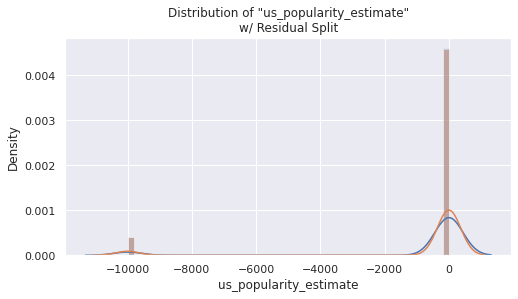

In [ ]:
plot("us_popularity_estimate")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


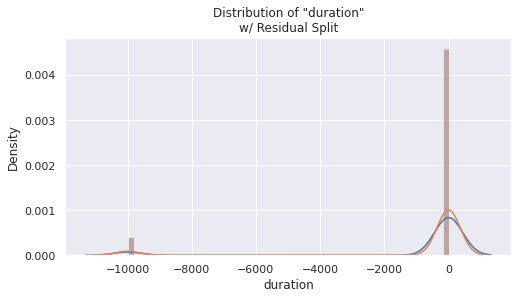

In [ ]:
plot("duration")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


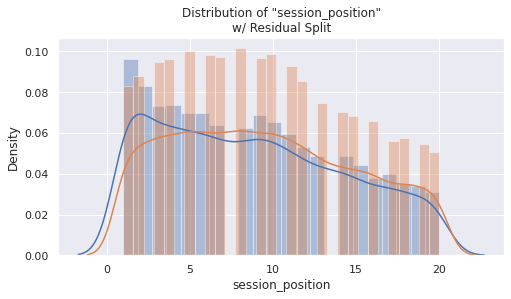

In [ ]:
plot("session_position")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


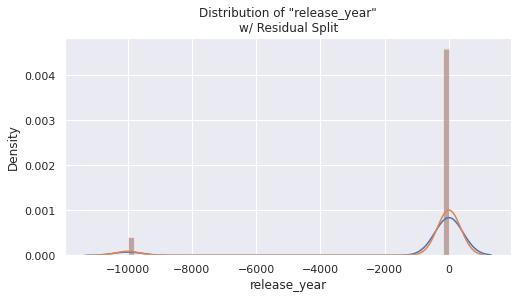

In [ ]:
plot("release_year")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


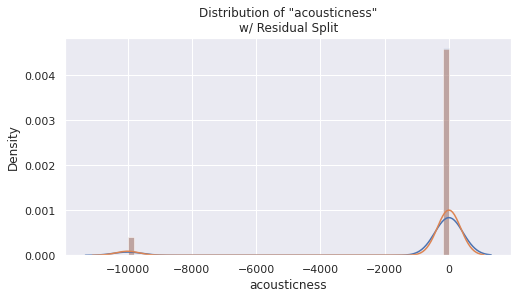

In [ ]:
plot("acousticness")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


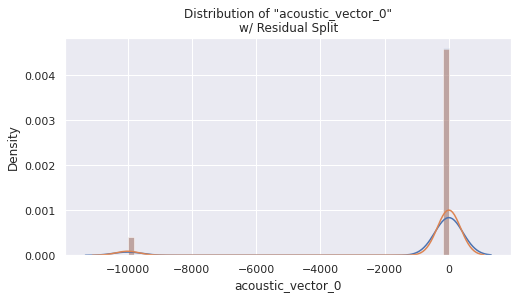

In [ ]:
plot("acoustic_vector_0")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


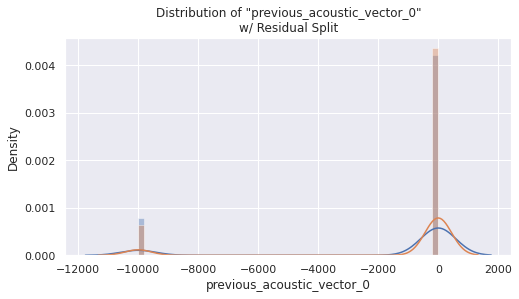

In [ ]:
plot("previous_acoustic_vector_0")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


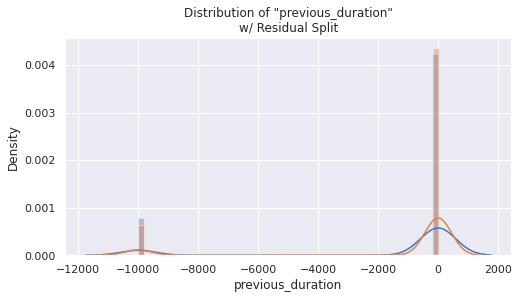

In [ ]:
plot("previous_duration")


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


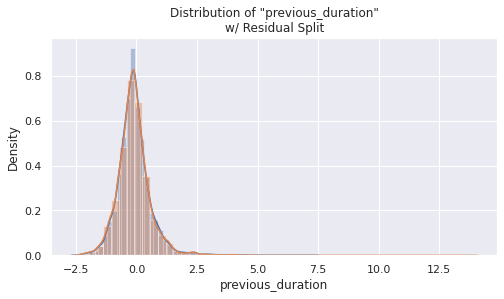

In [ ]:
# The N/A value is making it hard to see the main distribution

plt.figure(figsize=(8,4))
sns.distplot(
    X_test["previous_duration"][target_residuals & (X_test["previous_duration"] > -2000)],
    label="Residual > 0.6"
)
sns.distplot(
    X_test["previous_duration"][~target_residuals & (X_test["previous_duration"] > -2000)],
    label="Residual < 0.6"
)
plt.title(f"Distribution of \"{ 'previous_duration' }\"\nw/ Residual Split")
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


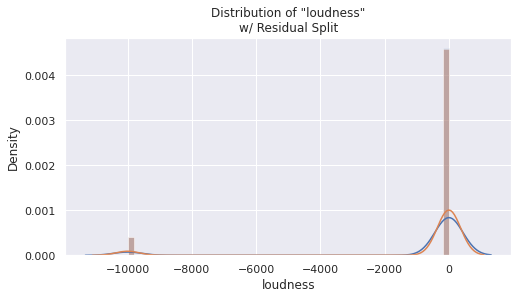

In [ ]:
plot("loudness")

In [ ]:
full_session_data.head()

,session_id,session_position,skipped,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,is_major,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,previous_session_position,previous_skipped,previous_duration,previous_release_year,previous_us_popularity_estimate,previous_acousticness,previous_beat_strength,previous_bounciness,previous_danceability,previous_dyn_range_mean,previous_energy,previous_flatness,previous_instrumentalness,previous_key,previous_liveness,previous_loudness,previous_mechanism,previous_is_major,previous_organism,previous_speechiness,previous_tempo,previous_time_signature,previous_valence,previous_acoustic_vector_0,previous_acoustic_vector_1,previous_acoustic_vector_2,previous_acoustic_vector_3,previous_acoustic_vector_4,previous_acoustic_vector_5,previous_acoustic_vector_6,previous_acoustic_vector_7
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1.0,0,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,-0.527006,1.0,0.693523,0.015848,0.438551,0.473455,0.653119,-0.148759,0.553465,1.035007,3.484468e-03,0.090909,0.678553,0.327754,0.546784,1.0,0.320668,0.069717,0.432284,0.571429,0.152255,-1.332878,0.813641,0.440978,0.131989,-0.844142,-0.143796,-0.599983,0.566763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2.0,0,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,0.165861,1.0,0.644089,0.061811,0.654804,0.735661,0.877393,1.327177,0.726828,1.025636,1.031315e-07,0.636364,0.104322,0.610232,0.824766,0.0,0.131391,0.061158,0.299963,0.571429,0.337152,-1.090160,0.735187,0.773410,-0.065046,-0.971432,0.160804,-0.631676,0.428458,1.0,0.0,-0.527006,1.0,0.693523,0.015848,0.438551,0.473455,0.653119,-0.148759,0.553465,1.035007,3.484468e-03,0.090909,0.678553,0.327754,0.546784,1.0,0.320668,0.069717,0.432284,0.571429,0.152255,-1.332878,0.813641,0.440978,0.131989,-0.844142,-0.143796,-0.599983,0.566763
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3.0,0,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,0.098324,1.0,0.715568,0.354116,0.532155,0.540411,0.679719,0.015381,0.563009,1.029465,2.659035e-08,0.909091,0.135776,0.492570,0.774327,1.0,0.296923,0.045354,0.797452,0.571429,0.373862,-1.158831,0.776265,0.534293,-0.084075,-0.758170,0.142758,-0.959950,0.496833,2.0,0.0,0.165861,1.0,0.644089,0.061811,0.654804,0.735661,0.877393,1.327177,0.726828,1.025636,1.031315e-07,0.636364,0.104322,0.610232,0.824766,0.0,0.131391,0.061158,0.299963,0.571429,0.337152,-1.090160,0.735187,0.773410,-0.065046,-0.971432,0.160804,-0.631676,0.428458
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4.0,0,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,-0.652071,1.0,0.712150,0.769225,0.641756,0.729224,0.864881,1.318616,0.529484,0.993520,6.598388e-06,0.090909,0.103722,0.063016,0.630996,1.0,0.603271,0.229936,-0.299281,0.571429,0.649420,-1.069886,0.575604,0.685594,-0.055785,-0.997492,0.318548,-0.629268,0.797080,3.0,0.0,0.098324,1.0,0.715568,0.354116,0.532155,0.540411,0.679719,0.015381,0.563009,1.029465,2.659035e-08,0.909091,0.135776,0.492570,0.774327,1.0,0.296923,0.045354,0.797452,0.571429,0.373862,-1.158831,0.776265,0.534293,-0.084075,-0.758170,0.142758,-0.959950,0.496833
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5.0,0,t_64f3743c-f624-46bb-a579-0f3f9a07a123,-0.154756,1.0,0.714545,0.006602,0.732428,0.794881,0.857778,1.680245,0.650057,1.000571,2.066649e-06,0.727273,0.120842,0.700050,0.759465,1.0,0.170148,0.240980,0.863928,0.571429,0.652921,-1.458160,0.623033,0.359345,0.291053,-0.843922,-0.390072,-1.023939,0.498887,4.0,0.0,-0.652071,1.0,0.712150,0.769225,0.641756,0.729224,0.864881,1.318616,0.529484,0.993520,6.598388e-06,0.090909,0.103722,0.063016,0.630996,1.0,0.603271,0.229936,-0.299281,0.571429,0.649420,-1.069886,0.575604,0.685594,-0.055785,-0.9

In [ ]:
session_ids = full_session_data.session_id.unique()
session_ids.shape

(10000,)

In [ ]:
past_sessions = [
    "0_05eb4c83-e0bd-4e12-b65e-9ccd18b39ef9"
]

In [ ]:
rid = np.random.choice(session_ids)
rid

'0_08988022-46cd-4300-80c8-97dc84b7016b'

In [ ]:
session = full_session_data[full_session_data.session_id == rid]
session

,session_id,session_position,skipped,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,is_major,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,previous_session_position,previous_skipped,previous_duration,previous_release_year,previous_us_popularity_estimate,previous_acousticness,previous_beat_strength,previous_bounciness,previous_danceability,previous_dyn_range_mean,previous_energy,previous_flatness,previous_instrumentalness,previous_key,previous_liveness,previous_loudness,previous_mechanism,previous_is_major,previous_organism,previous_speechiness,previous_tempo,previous_time_signature,previous_valence,previous_acoustic_vector_0,previous_acoustic_vector_1,previous_acoustic_vector_2,previous_acoustic_vector_3,previous_acoustic_vector_4,previous_acoustic_vector_5,previous_acoustic_vector_6,previous_acoustic_vector_7
98742,0_08988022-46cd-4300-80c8-97dc84b7016b,1.0,0,t_2959e1e2-67b5-4cf4-bc47-85fc2599845e,-0.200662,0.926471,0.285947,0.458537,0.268845,0.29014,0.276066,-0.846497,0.489349,0.983221,0.901973,1.0,0.212174,-0.278293,0.301923,0.0,0.590579,0.033156,1.733024,0.571429,0.655019,0.86619,-0.974927,-1.276769,-0.631893,0.698323,0.319548,-0.557926,-0.239506,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98743,0_08988022-46cd-4300-80c8-97dc84b7016b,2.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,-0.200662,0.926471,0.285947,0.458537,0.268845,0.29014,0.276066,-0.846497,0.489349,0.983221,0.901973,1.0,0.212174,-0.278293,0.301923,0.0,0.590579,0.033156,1.733024,0.571429,0.655019,0.86619,-0.974927,-1.276769,-0.631893,0.698323,0.319548,-0.557926,-0.239506
98744,0_08988022-46cd-4300-80c8-97dc84b7016b,3.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98745,0_08988022-46cd-4300-80c8-97dc84b7016b,4.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98746,0_08988022-46cd-4300-80c8-97dc84b7016b,5.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98747,0_08988022-46cd-4300-80c8-97dc84b7016b,6.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98748,0_08988022-46cd-4300-80c8-97dc84b7016b,7.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98749,0_08988022-46cd-4300-80c8-97dc84b7016b,8.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98750,0_08988022-46cd-4300-80c8-97dc84b7016b,9.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


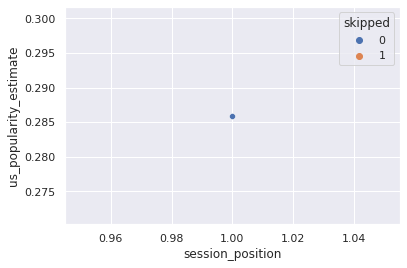

In [74]:
sns.scatterplot(
    session.session_position,
    session.us_popularity_estimate,
    hue=session.skipped
)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


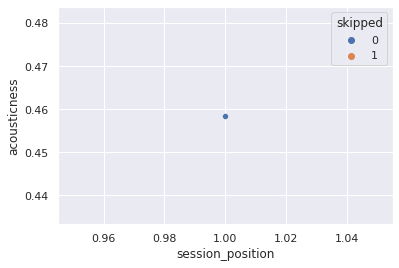

In [75]:
sns.scatterplot(
    session.session_position,
    session.acousticness,
    hue=session.skipped
)